## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, the results of an A/B test run by an e-commerce website will be analyzed.  The goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

Import required libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

`ab_data.csv` data stored in `df`.

Read in the dataset.

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


The number of rows in the dataset.

In [3]:
df.shape[0]

294478

The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

The proportion of users converted.

In [5]:
df.query('group == "control"')['converted'].mean()

0.12039917935897611

The number of times the `new_page` and `treatment` don't match.

In [6]:
df.query('group == "treatment" and landing_page != "new_page"').shape[0] + \
df.query('group == "control" and landing_page != "old_page"').shape[0]

3893

Check for rows with missing values.

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. These pages are removed.

In [8]:
# Drop rows as stated above

drop_rows = df.query('group == "treatment" and landing_page != "new_page"') & \
df.query('group == "control" and landing_page != "old_page"')
df2 = df.drop(drop_rows.index).reset_index(drop=True)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [9]:
# Double Check all of the correct rows were removed. Should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Unique **user_id**s in **df2**.

In [10]:
df2['user_id'].nunique()

290584

There is one **user_id** repeated in **df2**.

In [11]:
df2['user_id'].value_counts().head()

773192    2
630732    1
811737    1
797392    1
795345    1
Name: user_id, dtype: int64

Row information for the repeat **user_id**. 

In [12]:
df2[df2.duplicated(['user_id']) == True]

,user_id,timestamp,group,landing_page,converted
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**One** of the rows with a duplicate **user_id** removed.

In [13]:
df2 = df2.drop(2862, axis = 0)

In [14]:
df2.reset_index(drop=True);

Probability of an individual converting regardless of the page they receive.

In [15]:
df2['converted'].mean()

0.11959708724499628

Given that an individual was in the `control` group, probability they converted.

In [16]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

Given that an individual was in the `treatment` group, probability they converted.

In [17]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

Probability that an individual received the new page.

In [18]:
df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]

0.5000619442226688

Is this sufficient evidence to conclude that the new treatment page leads to more conversions?

**We do not have reason to believe the new treatment case leads to more conversions. The probability of conversion are essentially equal in the test group and control group, and they can be compared directly because the sample sizes are also equal i.e. 50% of individuals landed in the new page and 50% landed in the old page.**

<a id='ab_test'></a>
### Part II - A/B Test

Due to the time stamp associated with each event, a hypothesis test can technically be run continuously as each observation is observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

`1.` For now, decision is made based on just the data provided.  Assumption is made that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. Null and alternative hypotheses shown below. **$p_{old}$** and **$p_{new}$** are the converted rates for the old and new pages.

**Initial Hypothesis**

$$H_0: p_{old} - p_{new} \geq 0$$


$$H_1: p_{old} - p_{new} < 0$$



`2.` Assumption made under the null hypothesis that $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, they are assumed to be equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Sample size used for each page is equal to the ones in **ab_data.csv**.  <br><br>

Sampling distribution performed for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


**New Hypothesis**

$$H_0: p_{old} - p_{new} = 0$$


$$H_1: p_{old} - p_{new} \neq 0$$


**Conversion rate** for $p_{new}$ under the null.

In [19]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

**Conversion rate** for $p_{old}$ under the null.

In [20]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

$n_{new}$, the number of individuals in the treatment group.

In [21]:
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

$n_{old}$, the number of individuals in the control group.

In [22]:
n_old = df2.query('group == "control"').shape[0]
n_old

145274

$n_{new}$ transactions simulated with a conversion rate of $p_{new}$ under the null. $n_{new}$ 1's and 0's stored in **new_page_converted**.

In [23]:
new_page_converted = np.random.choice([0,1], size = n_new, p = [1-p_new, p_new])
new_page_converted.mean()

0.1193379671048104

$n_{old}$ transactions simulated with a conversion rate of $p_{old}$ under the null. $n_{old}$ values of 1's and 0's stored in **old_page_converted**.

In [24]:
old_page_converted = np.random.choice([0,1], size = n_old, p = [1-p_old, p_old])
old_page_converted.mean()

0.11933312223797789

The $p_{new}$ - $p_{old}$ for the simulated values from above.

In [25]:
p_new - p_old

0.0

10,000 $p_{new}$ - $p_{old}$ values created using the similar simulation process used above. 10,000 values stored in a NumPy array called **p_diffs**.

In [26]:
# Used numpy's random choice, essentially working same way as bootstrapping.

new_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_page_converted - old_page_converted

Histogram plot of the **p_diffs**. Normal distribution centered at null value of 0 is expected.

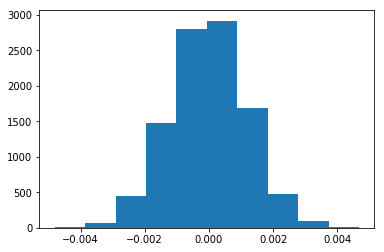

In [27]:
plt.hist(p_diffs);

Proportion of the **p_diffs** greater than the actual difference observed in **ab_data.csv**.

P-Value = 0.9081


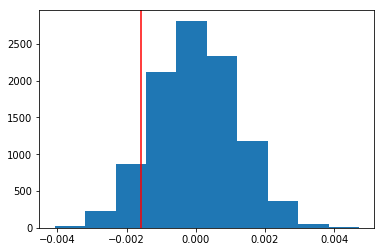

In [28]:
# Technically recentering not required in this case.
p_diffs = np.array(p_diffs)
null_sim = np.random.normal(0, p_diffs.std(), p_diffs.size)

p_old_actual = df2.query('group == "control"')['converted'].mean()
p_new_actual = df2.query('group == "treatment"')['converted'].mean()
act = p_new_actual - p_old_actual

p_value = (null_sim > act).mean()
print('P-Value =', p_value)

plt.hist(null_sim)
plt.axvline(x = act, color = 'red');


The value calculted above and its relationship to the difference between the new and old pages

**The value calculated above is the p-value. The p-value here is quite large therefore you would not move away from the null hypothesis which suggests that the old page has an equal conversion rate as the new page. However, since the Type 1 error rate is 0.05, the p-value would have to be 95% or greater in order to confidently make this statement.**

Below is the number of conversions for each page, as well as the number of individuals who received each page. `n_old` and `n_new` refer to the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"')['converted'].mean()
convert_new = df2.query('landing_page == "new_page"')['converted'].mean()
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


`stats.proportions_ztest` used to compute test statistic and p-value. 

In [30]:
stat, p_val = sm.stats.proportions_ztest([convert_new, convert_old], [n_new,n_old], alternative = "two-sided",value = 0)
stat , p_val

(-0.0032875796753531767, 0.99737689565979126)

The relationship between the z-score and p-value computed above with the conversion rates of the old and new pages and comparison with p-value from null simulation.

**The z-score here indicates the difference is almost centered at the mean value of 0. The p-value inidicates strong support in favor of the null hypothesis ie we cannot reject the null hypothesis. These findings are close to the results calculated above, but when taking the Type 1 error rate into account, then yes, they are different. The statsmodel show stronger support in favor of the null.**

<a id='regression'></a>
### Part III - A regression approach

`1.` The result achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

Since each row is either a conversion or no conversion, **Logistic Regression** should be used to model this case.

The goal is to use **statsmodels** to fit the regression model specified above to see if there is a significant difference in conversion based on which page a customer receives.

In [31]:
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


**statsmodels** used to instantiate regression model on the two columns created in part b., then model is fit using these two columns to predict whether or not an individual converts. 

In [32]:
log_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Summary of the model.

In [33]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 07 Mar 2019   Pseudo R-squ.:               8.077e-06
Time:                        02:33:23   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [34]:
# Exponentiate coefficients from logistic model

np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

The p-value associated with **ab_page** and why it differs from the value found in **Part II**?

**P-Value of ab_page is 0.19. This differs from the p-value in Part II because the null hypothesis in Part II is $H_0: p_{old} - p_{new} \geq 0$. The logistic model outputs a p-value from a two-tailed test. The hypotheses that the logistic regression assumes is represented by $H_0: p_{old} - p_{new} = 0$. In order to make an apples to apples comparison, the p-value from the logistic model should first be divided by half (0.095), allowing us to look at only one tail of the distribution. Since the p-value here represents the probability that new users will definitely convert, we must subtract 1 - 0.095 = 0.905. This is the p-value that correlates to the null hypothesis, $H_0: p_{old} - p_{new} \geq 0$ .** **For comparison, the p-values from Part II and Part III are 0.908 and 0.905 (after converting), respectively.** 

Why it is a good idea to consider other factors to add into the regression model and any disadvantages to adding additional terms into the regression model.

**More variables may be added to the regression model in order to understand the impact or significance of a variable on the response. However, an assumption of regression is non-collinearity between covariates. By adding more variables, collinearity may be introduced into the model ie. the independent variables, too some degree, are correlated to eachother rather than only the response. VIF testing should be conducted when adding more variables.**

Along with testing if the conversion rate changes for different pages, an effect based on which country a user lives in is added.

In [35]:
country = pd.read_csv('countries.csv')
df3 = df2.merge(country, on = 'user_id')
df3[['CA', 'UK', 'US']] = pd.get_dummies(df3['country'])

log_model2 = sm.Logit(df3['converted'], df3[['intercept', 'CA', 'UK']])
results2 = log_model2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 07 Mar 2019   Pseudo R-squ.:               1.521e-05
Time:                        02:33:25   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

In [36]:
np.exp(results2.params)

intercept    0.135779
CA           0.960018
UK           1.009966
dtype: float64

The interaction between page and country to see if there are significant effects on conversion. Necessary additional columns created, and new model is fit.

Summary of results and conclusion provided below.

In [37]:
# Column 'ab_page' is equivalent to new_page, but dummies still created.
# Baseline is US users that land on the old page. 

df3[['new_page','old_page']] = pd.get_dummies(df3['landing_page'])
log_model3 = sm.Logit(df3['converted'], df3[['intercept', 'CA', 'UK','new_page']])
results3 = log_model3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 07 Mar 2019   Pseudo R-squ.:               2.323e-05
Time:                        02:33:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
new_page      -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

In [38]:
np.exp(results3.params)

intercept    0.136795
CA           0.960062
UK           1.009932
new_page     0.985168
dtype: float64

In [39]:
# Check for any multicollinearity between variables

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

y, X = dmatrices('converted ~ CA + UK + new_page', df3, return_type = 'dataframe')
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['features'] = X.columns
vif

,VIF Factor,features
0,2.428940,Intercept
1,1.017759,CA
2,1.017761,UK
3,1.000006,new_page


<a id='conclusions'></a>
**Based on the results of the logistic model, the conversion rates in Canada and UK are equivalent to that in the US holding all else constant, and the conversion rate for users on the new page is equivalent to that of the old page, holding the countries constant. Although, the P values show that the variables do not appear to have a statistically significant relationship with conversion. We can cautiously conclude that despite what country users are accessing the page from, there is no significant advantage of launching the new page in regards to conversion rate, so resources of the company should not be wasted implementing and launching the new page. Running the test longer could provide more significance in these results.**

In [40]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0